In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing

df = pd.read_csv('/content/drive/MyDrive/Data/twitter_data.csv')

# Check for missing values

print(df.isnull().sum())

# Check skewness and adjust with log function

print(f"label skewness: {df['retweets'].skew()}")

df['retweets'] = np.log(df['retweets'] + 1)

print(f"label skewness: {df['retweets'].skew()}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


id                    0
retweets              0
likes                 0
replies               0
location              0
language              0
possibly sensitive    0
image_url             0
text                  0
dtype: int64
label skewness: 11.584723153780754
label skewness: -0.24899190645228086


## **MLR Model**

In [ ]:
# Build MLR model with retweets as the label

label = "retweets"
df2 = df.copy()

# drop unstructured features
df = df.drop(columns=['image_url', 'text', 'location'])

# Generate dummy variables
for col in df:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = df.join(pd.get_dummies(df[col], prefix=col, drop_first=True))

# drop insignificant features (in this case those with p-value > 0.20)
df = df.drop(columns=['id', 'language_pt', 'language_en', 'language_fr', 'language_pl'])

df_og = df.select_dtypes(np.number)

# Min-Max Normalization
df_minmax = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df_og), columns=df_og.columns)

# Set label and features
y = df_minmax[label]                    
X = df_minmax.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=[label])

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     80.35
Date:                Mon, 01 Nov 2021   Prob (F-statistic):          3.29e-102
Time:                        22:48:59   Log-Likelihood:                 73.230
No. Observations:                1000   AIC:                            -128.5
Df Residuals:                     991   BIC:                            -84.29
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
likes            1.0618      0.375      2.833   

## **Decision Tree Model**

In [ ]:
# Build a Decision Tree model with "possibly sensitive" as the label

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# drop unstructured features
df2 = df2.drop(columns=['image_url', 'text', 'location'])

for col in df2.columns:
  if col != 'possibly sensitive':
    if not pd.api.types.is_numeric_dtype(df2[col]):
      df2 = pd.get_dummies(df2, columns=[col], prefix=col)

y = df2['possibly sensitive'] # Label
X = df2.drop(columns=['possibly sensitive']) # Features
X = X.select_dtypes(np.number)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clf.predict(X_test)

# Several of these metrics have to work off of dummy codes rather than categorical values
y_test_dummies = pd.get_dummies(y_test)
y_pred_dummies = pd.get_dummies(y_pred)

# Accuracy = (true positives + true negatives) / (total cases)
print(f"Accuracy:\t{metrics.accuracy_score(y_test, y_pred)}")

Accuracy:	0.9


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


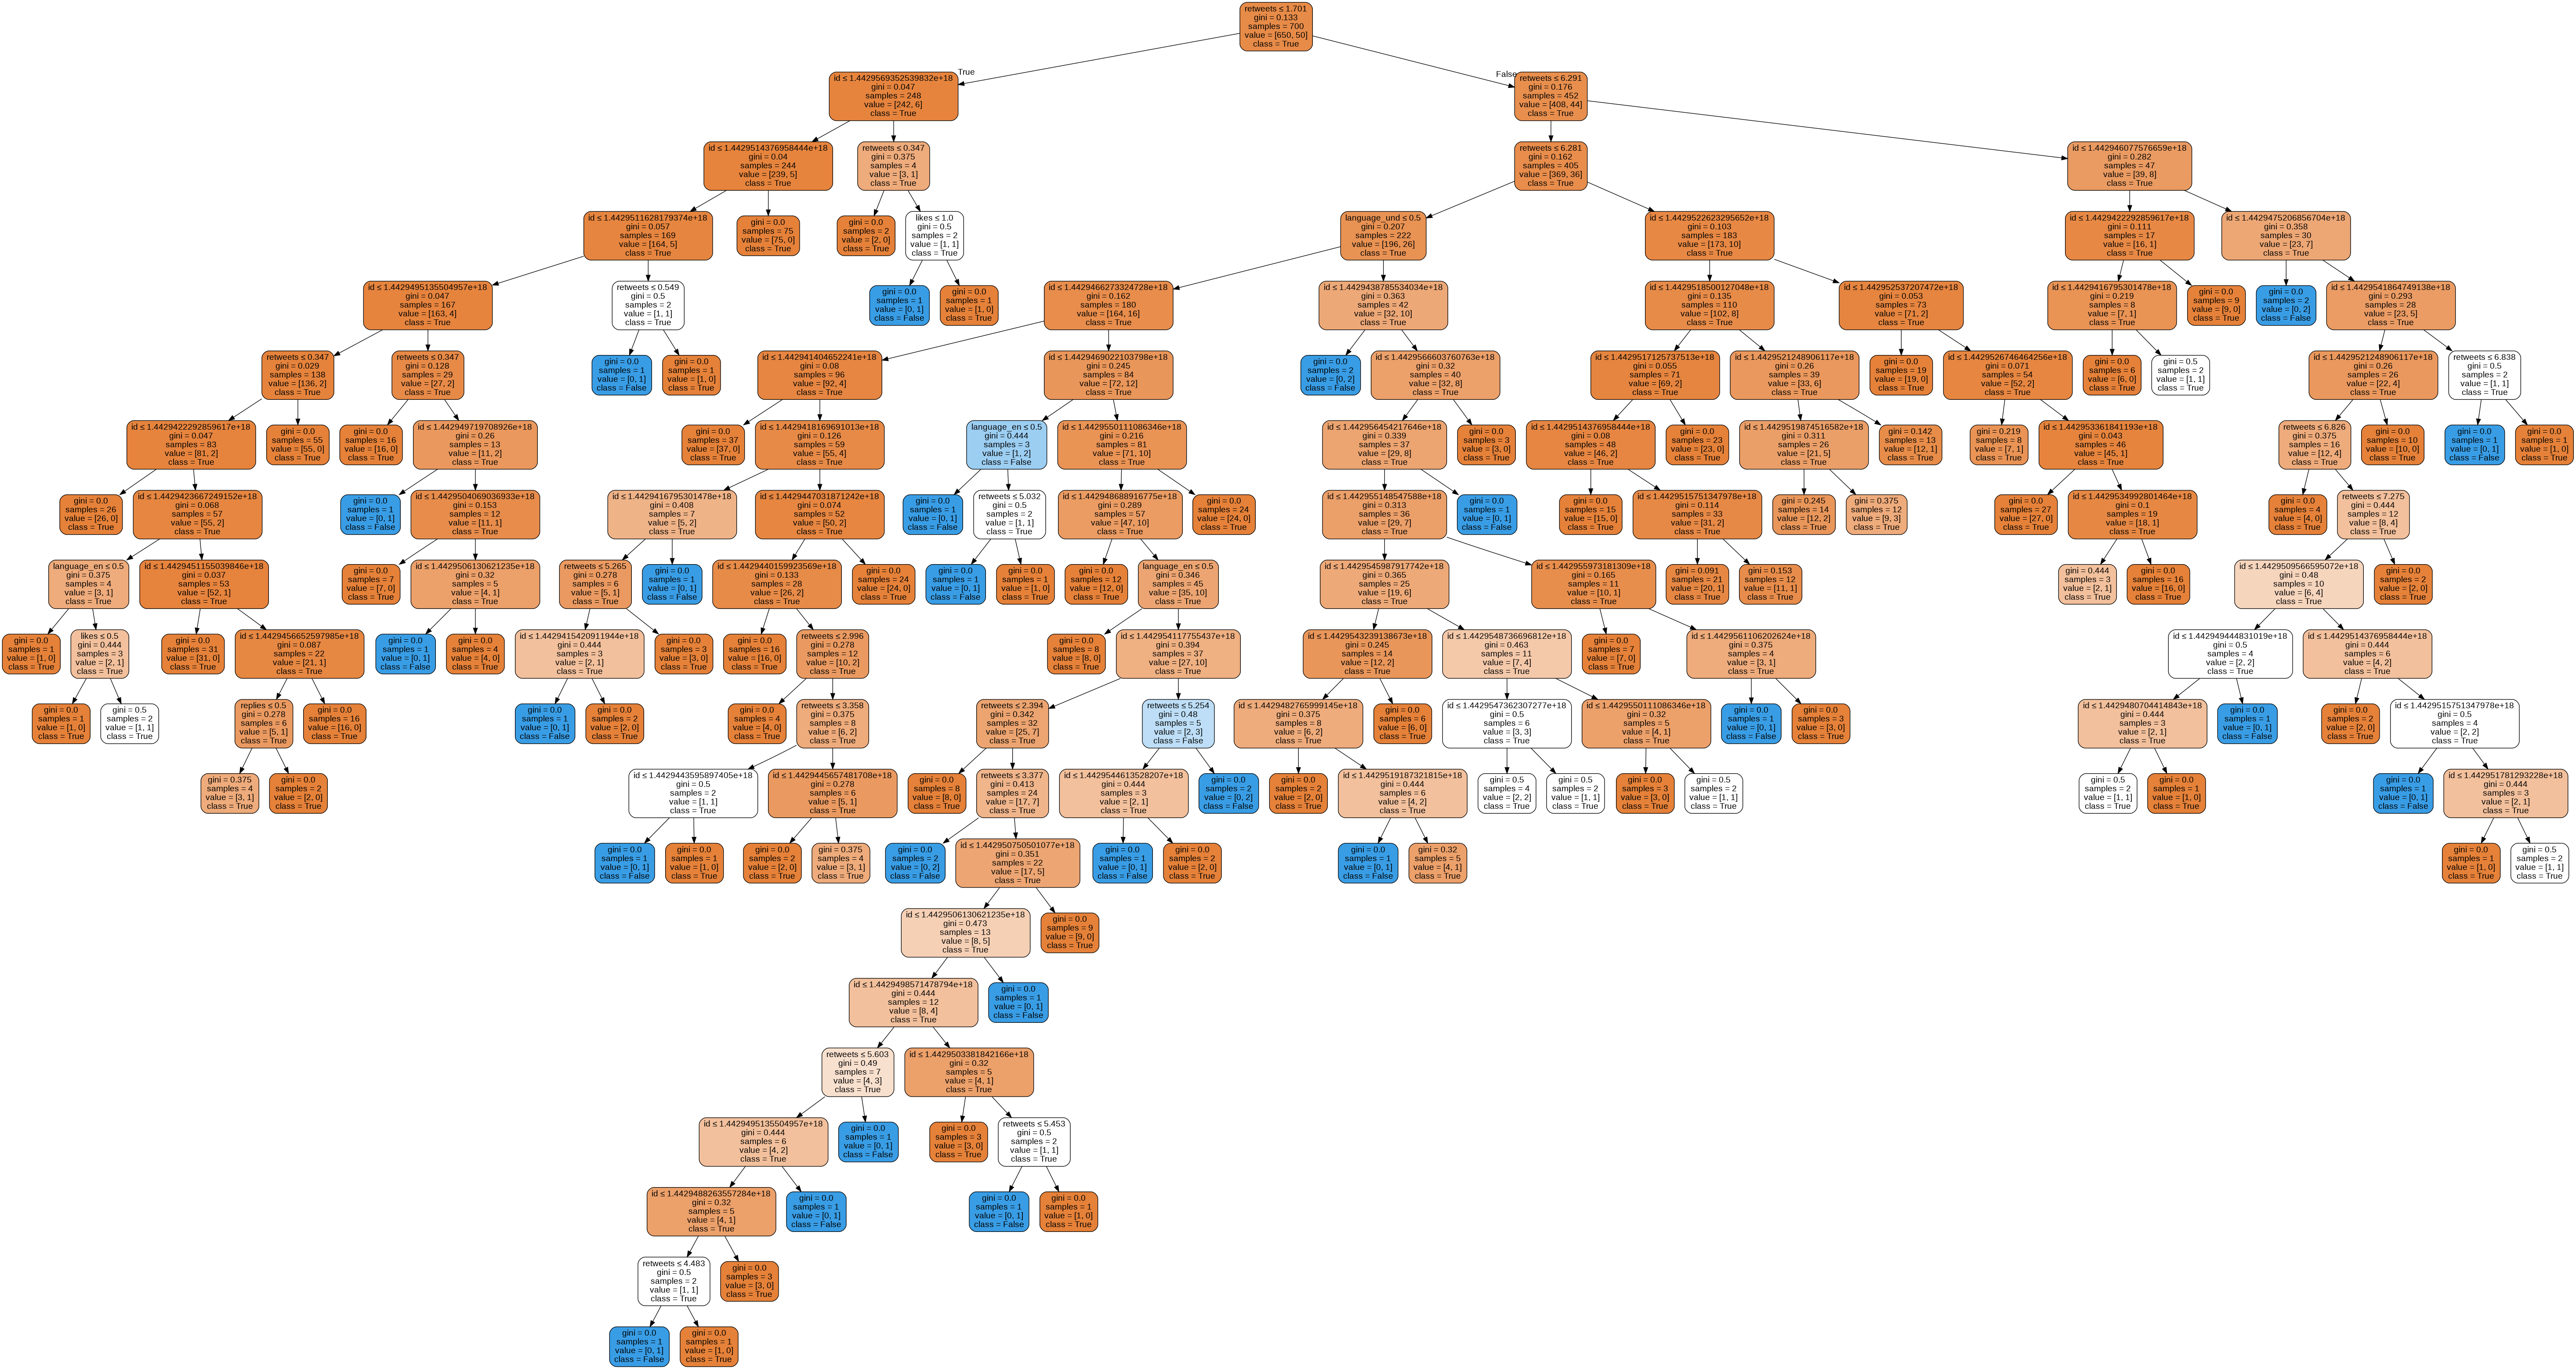

In [ ]:
# Create a visualization of the Decision Tree model to view results

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus, six

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = X.columns,class_names=['True', 'False'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

## **Cluster Model**

In [ ]:
# Build Agglomerative clustering model using Gower matrix as distance measure

from sklearn.cluster import AgglomerativeClustering
!pip install gower
import gower

distance_matrix = gower.gower_matrix(df2)

agg = AgglomerativeClustering(affinity='precomputed', linkage='average').fit(distance_matrix)
df_wcluster = df2.copy()
df_wcluster['cluster'] = agg.labels_

df_wcluster.cluster.value_counts()

0    666
1    334
Name: cluster, dtype: int64